<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [439]:
import pandas as pd
import numpy as np
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [440]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python
 

In [441]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [442]:
# текст запроса
query_3_1 = f'''select
                    count(*) "Количество вакансий"
                from
                    public.vacancies
'''

In [443]:
# результат запроса
vacan_qty = pd.read_sql_query(query_3_1, connection)
answer = vacan_qty['Количество вакансий'][0]
#display(vacan_qty)
print(f'Количество вакансий составляет: {answer}')

Количество вакансий составляет: 49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [444]:
# текст запроса
query_3_2 = f'''select
                    count(*) "Количество работадателей"
                from
                    public.employers
'''

In [445]:
# результат запроса\
employer_qty = pd.read_sql_query(query_3_2, connection)
answer = employer_qty['Количество работадателей'][0]
#display(employer_qty)
print(f'Количество работадателей составляет: {answer}')

Количество работадателей составляет: 23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [446]:
# текст запроса
query_3_3 = f'''select
                    count(*) "Количество регионов"
                from 
                    public.areas
'''

In [447]:
# результат запроса
area_qty = pd.read_sql_query(query_3_3, connection)
#display(area_qty)
answer = area_qty['Количество регионов'][0]
print(f'Количество регионов составляет: {answer}')

Количество регионов составляет: 1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [448]:
# текст запроса
query_3_4 = '''select
                    count(*) "Количество сфер деятельности"
                from
                    public.industries
'''

In [449]:
# результат запроса
indust_qty = pd.read_sql_query(query_3_4, connection)
#display(indust_qty)
answer = indust_qty['Количество сфер деятельности'][0]
print(f'Количество сфер деятельности составляет: {answer}')

Количество сфер деятельности составляет: 294


***

In [450]:
# выводы по предварительному анализу данных
totals = pd.concat([vacan_qty, employer_qty, area_qty, indust_qty], axis=1)
totals['Вакансии в регионе (среднее)'] = round(totals['Количество вакансий'] / totals['Количество регионов'])
totals['Вакансий на работодателя (среднее)'] = round(totals['Количество вакансий'] / totals['Количество работадателей'])
display(totals)



,Количество вакансий,Количество работадателей,Количество регионов,Количество сфер деятельности,Вакансии в регионе (среднее),Вакансий на работодателя (среднее)
0,49197,23501,1362,294,36.0,2.0


Предварительный анализ показывает, что при относительно большом количестве работодателей и регионов, количество вакансий достаточно скромное (всего две вакансии в среднем на работодателя и 36 вакансий в среднем в каждом регионе). Это может свидетельствовать о том, что далеко не во всех регионах вакансии распределены равномерно: есть регионы с очень большим количеством вакансий (наиболее крупные города), в небольших городах ситуация абсолютно противоположная - такие города зачастую сами являются донорами трудовых ресурсов для крупных городов, исключением могут являться небольшие города, куда в основном приезжают работать вахтовым методом (добыча полезных ископаемых, сезонная работа по добыче биоресурсов (например, путина лосося на Дальнем Востоке), моногорода с крупными промышленными предприятиями). Аналогично вакансии очень неравномерно распределены и среди работодателей - у крупных команий могут быть сотни вакансий, тогда как у небольших предприятий всего одна - две вакансии. Дальнейший анализ покажет, как же происходит распределение вакансий, и какие работодатели преобладают на рынке.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [451]:
# текст запроса
query_4_1 = '''select
                    a.name "Регион",
                    count(v.id) "Количество вакансий"
                from 
                    public.areas a
                join 
                    public.vacancies v on a.id = v.area_id
                group by 1
                order by 2 desc
'''

In [452]:
# результат запроса
area_vacan = pd.read_sql_query(query_4_1, connection)
print('Регионы-лидеры по количеству вакансий:')
display(area_vacan.head())

Регионы-лидеры по количеству вакансий:


,Регион,Количество вакансий
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [453]:
# текст запрос
query_4_2 = '''select
                    'ЗП указана' "Указана ли ЗП?",    
                    count(*) "Количество вакансий"
                from
                    public.vacancies
                where 
                    salary_from is not null
                or 
                    salary_to is not null
                    
                union all
                
                select
                    'ЗП не указана',
                    count(*)
                from
                    public.vacancies
                where 
                    salary_from is null and salary_to is null
                order by 2    
                
'''

In [454]:
# результат запроса
vacan_salaries = pd.read_sql_query(query_4_2, connection)
#display(vacan_salaries)
#answer = vacan_salaries['Вакансии с заполненной ЗП'][1]
#print(f'Количество вакансий с заполненными полями ЗП составляет: {answer}')

display(vacan_salaries)

,Указана ли ЗП?,Количество вакансий
0,ЗП указана,24073
1,ЗП не указана,25124


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [455]:
# текст запроса
query_4_3 = '''select
                    round(avg(salary_from)) "Среднее нижней границы ЗП",
                    round(avg(salary_to)) "Среднее верхней границы ЗП"
                from
                    public.vacancies
'''

In [456]:
# результат запроса
avg_salaries = pd.read_sql_query(query_4_3, connection)
#display(avg_salaries)
answer = avg_salaries.loc[0]
print(f'Среднее значение нижней границы зарплатной вилки: {answer[0]} рублей')
print(f'Среднее значение верхней границы зарплатной вилки: {answer[1]} рублей')

Среднее значение нижней границы зарплатной вилки: 71065.0 рублей
Среднее значение верхней границы зарплатной вилки: 110537.0 рублей


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [457]:
# текст запроса
query_4_4 = '''select                    
                    schedule || '/' || employment "График/Трудоустройство",
                    count(*) "Количество вакансий"
                from
                    public.vacancies
                group by schedule, employment
                order by 2 desc 
'''

In [458]:
# результат запроса
schedule_employment = pd.read_sql_query(query_4_4, connection)
display(schedule_employment)
print()
print('Вторая по популярности пара "график работы - тип трудоустройства":')
display(schedule_employment.iloc[[1]])


,График/Трудоустройство,Количество вакансий
0,Полный день/Полная занятость,35367
1,Удаленная работа/Полная занятость,7802
2,Гибкий график/Полная занятость,1593
3,Удаленная работа/Частичная занятость,1312
4,Сменный график/Полная занятость,940
5,Полный день/Стажировка,569
6,Вахтовый метод/Полная занятость,367
7,Полный день/Частичная занятость,347
8,Гибкий график/Частичная занятость,312
9,Полный день/Проектная работа,141



Вторая по популярности пара "график работы - тип трудоустройства":


,График/Трудоустройство,Количество вакансий
1,Удаленная работа/Полная занятость,7802


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [459]:
# текст запроса
query_4_5 = '''select
                    experience "Требуемый опыт работы",
                    count(*) "Количество вакансий"                    
                from
                    public.vacancies
                where experience is not null
                group by 1
                order by count(*) 
'''

In [460]:
# результат запроса
exp_info = pd.read_sql_query(query_4_5, connection)
display(exp_info)

,Требуемый опыт работы,Количество вакансий
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

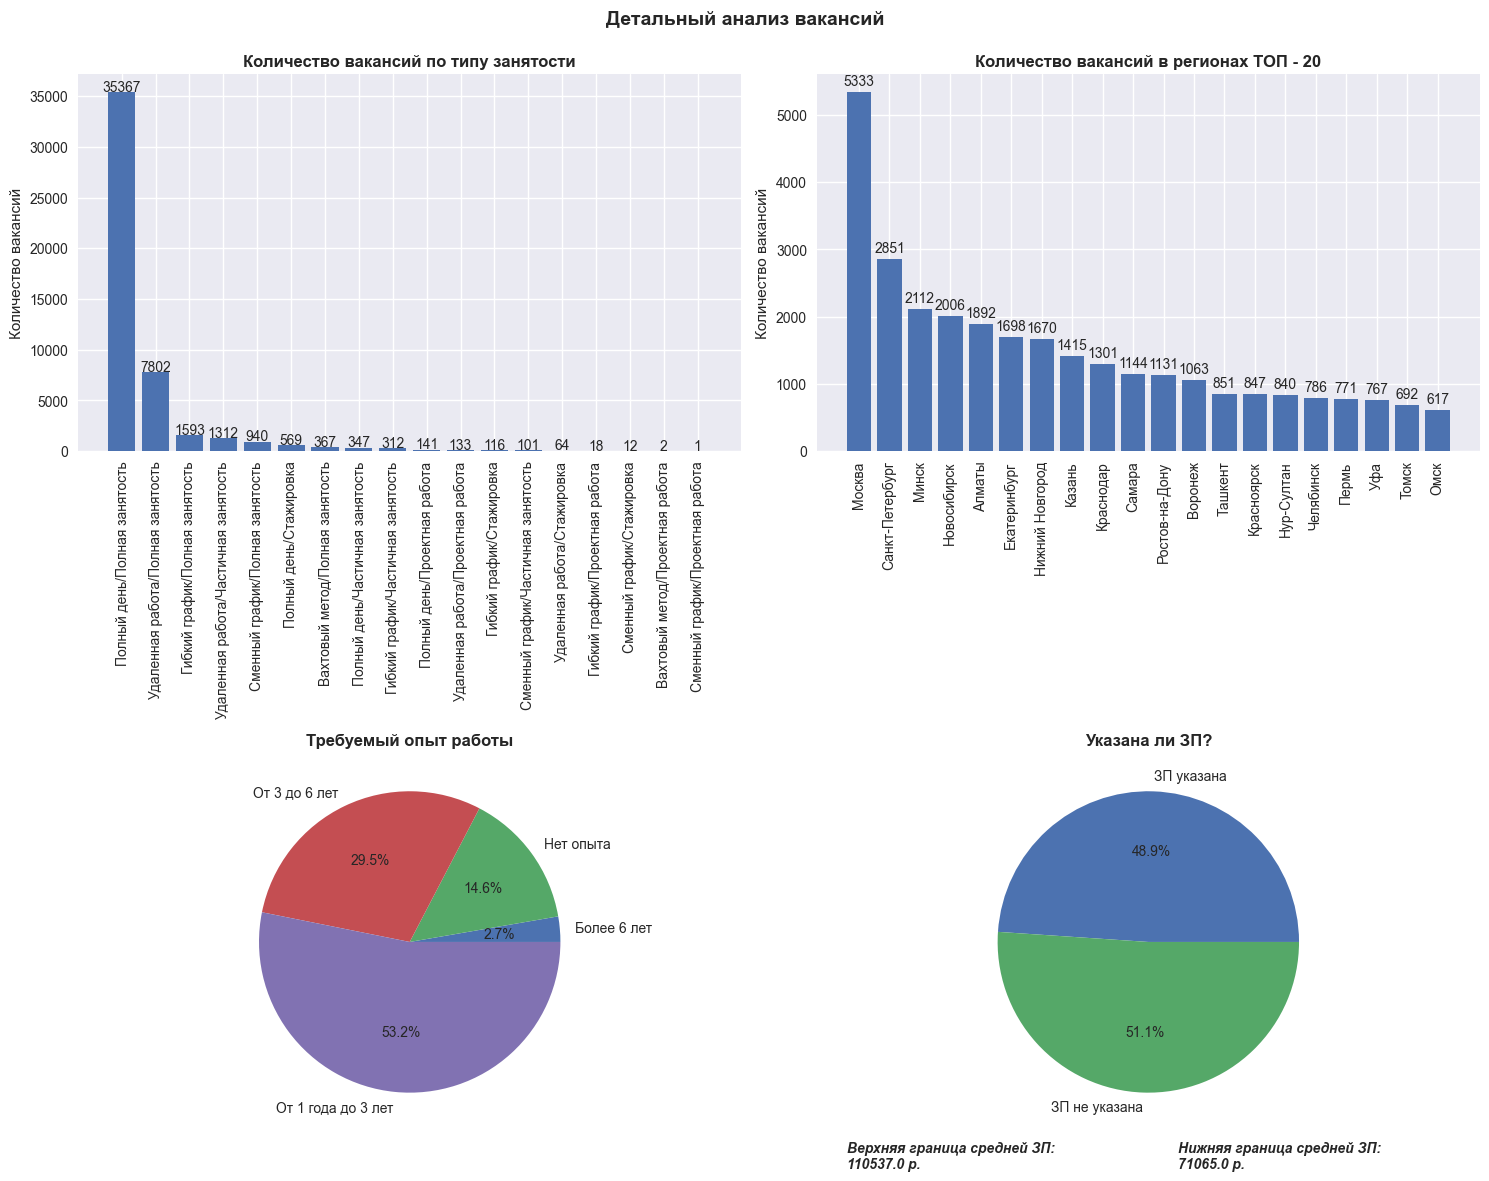

In [461]:
# выводы по детальному анализу вакансий

# Данные для первого bar chart
employment_data_x = schedule_employment['График/Трудоустройство'].to_list()
employment_data_y = schedule_employment['Количество вакансий'].to_list()

# Данные для второго bar chart
region_data = area_vacan['Регион'].to_list()[:20]
vacan_qty = area_vacan['Количество вакансий'].to_list()[:20]

# Данные для первого pie chart
experience_data = exp_info['Количество вакансий'].to_list()
experience_labels = exp_info['Требуемый опыт работы'].to_list()

# Данные для второго pie chart
salary_data = vacan_salaries['Количество вакансий'].to_list()
salary_labels = vacan_salaries['Указана ли ЗП?'].to_list()

# Создание subplot
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Детальный анализ вакансий\n', fontsize=14, fontweight='bold')

# Bar chart для Типа занятости
ax1 = axes[0, 0]
ax1.bar(employment_data_x, employment_data_y)
ax1.set_title("Количество вакансий по типу занятости", fontweight='bold')
ax1.set_ylabel("Количество вакансий")
ax1.tick_params(axis='x', rotation=90)
for i, v in enumerate(employment_data_y):
    ax1.text(i, v + 100, str(v), ha='center')


# Bar chart для Регионов
ax2 = axes[0, 1]
ax2.bar(region_data, vacan_qty)
ax2.set_title("Количество вакансий в регионах ТОП - 20", fontweight='bold')
ax2.set_ylabel("Количество вакансий")
ax2.tick_params(axis='x', rotation=90)
for i, v in enumerate(vacan_qty):
    ax2.text(i, v + 100, str(v), ha='center')

# Pie chart для Требуемого опыта работы
ax3 = axes[1, 0]
ax3.pie(experience_data, labels=experience_labels, autopct='%1.1f%%')
ax3.set_title("Требуемый опыт работы", fontweight='bold')

# Pie chart для Указания ЗП
ax4 = axes[1, 1]
ax4.pie(salary_data, labels=salary_labels, autopct='%1.1f%%')
ax4.set_title("Указана ли ЗП?", fontweight='bold')
ax4.text(0.2, - 1.5,  f'Нижняя граница средней ЗП:\n{avg_salaries.loc[0][0]} р.', style='oblique', fontweight='bold')
ax4.text( - 2, - 1.5,  f'Верхняя граница средней ЗП:\n{avg_salaries.loc[0][1]} р.', style='oblique', fontweight='bold')

# Отобразить графики
plt.tight_layout()
plt.show()

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [462]:
# текст запроса
query_5_1 = '''(select
                    e.name "Работодатель"                    
                from
                    public.vacancies v
                join 
                    public.employers e on e.id = v.employer_id
                group by 1
                order by count(v.id) desc
                limit 1)
                
                union all
                
                (select
                    e.name "Работодатель"                    
                from
                    public.vacancies v
                join 
                    public.employers e on e.id = v.employer_id
                group by 1
                order by count(v.id) desc
                offset 4
                limit 1)                
'''

In [463]:
# результат запроса
employer_info = pd.read_sql_query(query_5_1, connection)
answer = employer_info['Работодатель']
print(f'Работодатели, находящиеся на первом и пятом месте по количеству вакансий: {answer[0]} и {answer[1]}')


Работодатели, находящиеся на первом и пятом месте по количеству вакансий: Яндекс и Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [464]:
# текст запроса
query_5_2 = '''(select
                    a.name "Регион",
                    count(distinct v.employer_id) "Количество работодателей",
                    count(v.id) "Количество вакансий"                                       
                from
                    public.vacancies v
                join 
                    public.areas a on a.id = v.area_id
                group by a.id
                order by 2 desc)
                
                union all
                
                (select
                    a.name "Регион",
                    count(distinct e.id) "Количество работодателей",
                    count(v.id) "Количество вакансий"                                       
                from
                    public.areas a                    
                left join 
                    public.vacancies v on a.id = v.area_id
                join
                    public.employers e on a.id = e.area
                where v.id is null
                group by a.id
                order by 2 desc
                limit 1)             
'''

In [465]:
# результат запроса
employer_qty_area = pd.read_sql_query(query_5_2, connection)
answer = employer_qty_area[employer_qty_area['Количество вакансий'] == 0].iloc[0, 0]
display(employer_qty_area.head())
print(f'Регион с наибольшим количеством работодателей, и в котором нет вакансий: {answer}')
display(employer_qty_area.tail(1))


,Регион,Количество работодателей,Количество вакансий
0,Москва,2320,5333
1,Санкт-Петербург,1451,2851
2,Минск,851,2112
3,Новосибирск,802,2006
4,Алматы,798,1892


Регион с наибольшим количеством работодателей, и в котором нет вакансий: Россия


,Регион,Количество работодателей,Количество вакансий
769,Россия,410,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [466]:
# текст запроса
query_5_3 = ''' select
                    e.name "Работодатель",
                    count(distinct v.area_id) "Количество регионов"                                                          
                from
                    public.employers e                    
                join 
                    public.vacancies v on e.id = v.employer_id                
                group by e.id
                order by 2 desc                            
'''

In [467]:
# результат запроса
employer_area = pd.read_sql_query(query_5_3, connection)
answer = employer_area['Количество регионов'].max()
print(f'Максимальное количество регионов, где один работодатель разместил свои резюме, составляет: {answer}')
display(employer_area.head())

Максимальное количество регионов, где один работодатель разместил свои резюме, составляет: 181


,Работодатель,Количество регионов
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [468]:
# текст запроса
query_5_4 = ''' select
                    count(*) "Количество работодателей"                                                          
                from
                    public.employers e                    
                left join 
                    public.employers_industries i on e.id = i.employer_id
                where i.employer_id is null                                          
'''

In [469]:
# результат запроса
employer_without_indust = pd.read_sql_query(query_5_4, connection)
## employer_without_indust
answer = employer_without_indust['Количество работодателей'][0]
print(f'Количество работодателей, у которых не указана сфера деятельности: {answer}')

Количество работодателей, у которых не указана сфера деятельности: 8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [470]:
# текст запроса
query_5_5 = ''' select
                    e.name,
                    count(i.industry_id) "Количество сфер деятельности"                                                          
                from
                    public.employers e                    
                join 
                    public.employers_industries i on e.id = i.employer_id
                group by 1
                having count(i.industry_id) = 4
                order by 1
                offset 2
                limit 1                                         
'''

In [471]:
# результат запроса
employer_indust_qty = pd.read_sql_query(query_5_5, connection)
answer = employer_indust_qty['name'][0]
print(f'Hазвание компании, находящейся на третьем месте в алфавитном списке (по названию) компаний,\nу которых указано четыре сферы деятельности: {answer}')

Hазвание компании, находящейся на третьем месте в алфавитном списке (по названию) компаний,
у которых указано четыре сферы деятельности: 2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [472]:
# текст запроса
query_5_6 = ''' select
                    count(e.id) "Количество работодателей"                                                      
                from
                    public.employers e                    
                join 
                    public.employers_industries ei on e.id = ei.employer_id
                join
                    public.industries i on ei.industry_id = i.id
                where i.name like 'Разработка программного обеспечения'                                         
'''

In [473]:
# результат запроса
employer_indust_name = pd.read_sql_query(query_5_6, connection)
answer = employer_indust_name['Количество работодателей'][0]
print(f'Количество работодателей, у которых в качестве сферы \nдеятельности указана "Разработка программного обеспечения: {answer}')

Количество работодателей, у которых в качестве сферы 
деятельности указана "Разработка программного обеспечения: 3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [474]:
# код для получения списка городов-милионников - способ 1
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'
response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
rows = page.find('table', class_='standard sortable').find_all('a')[4:]
million_city_list = [row.text for row in rows]
print('Список городов - миллионников:\n\n', million_city_list)

Список городов - миллионников:

 ['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Красноярск', 'Челябинск', 'Самара', 'Уфа', 'Ростов-на-Дону', 'Краснодар', 'Омск', 'Воронеж', 'Пермь', 'Волгоград']


In [475]:
# код для получения списка городов-милионников - способ 2 (спарсил всю таблицу с википедии)
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'
response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
rows = page.find('table', class_='standard sortable').find_all('tr')[1:]
columns = page.find('table', class_='standard sortable').find_all('tr')[0]

def extract_column_values(columns):
    data = [value for value in columns.find_all('th')]
    extacted_data = [i.text for i in data]
    return extacted_data

def extract_row_values(rows):
    table_rows = []
    for row in rows:
        table_data = row.find_all('td')
        data = [value.text for value in table_data]
        table_rows.append(data)
    return table_rows

df_col_names = extract_column_values(columns)
df_rows = extract_row_values(rows)        
df_million_cities = pd.DataFrame(data = df_rows, columns = df_col_names)
df_million_cities = df_million_cities.drop('№', axis = 1)
display(df_million_cities.head(2))
print('Список городов - миллионников:\n\n', df_million_cities['Город'].to_list())

,Город,"Население, тыс. чел. (на 1 января 2023 года)","Население, тыс. чел. (итоги переписи 2021 года)[5]",Прирост относительно переписи-2010,"Население, тыс. чел.(итоги переписи 2010 года)[6]"
0,Москва,13 098,13 010,"13,1 %",11 504
1,Санкт-Петербург,5 598,5 602,"14,8 %",4 880


Список городов - миллионников:

 ['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Красноярск', 'Челябинск', 'Самара', 'Уфа', 'Ростов-на-Дону', 'Краснодар', 'Омск', 'Воронеж', 'Пермь', 'Волгоград']


In [476]:
# текст запроса
million_city_list = df_million_cities['Город'].to_list()

query_5_7 = f'''(select
                    a.name "Город",
                    count(v.id)  "Количество вакансий"                                                        
                from
                    public.areas a                    
                join 
                    public.vacancies v on a.id = v.area_id
                join
                    public.employers e on e.id = v.employer_id
                where
                    a.name in {(*million_city_list, )} 
                and
                    e.name = 'Яндекс'
                group by 1
                )
                    
                union all
                
                (select
                    'total',
                    count(v.id)                                                          
                from
                    public.areas a                    
                join 
                    public.vacancies v on a.id = v.area_id
                join
                    public.employers e on e.id = v.employer_id
                where
                    a.name in {(*million_city_list, )} 
                and
                    e.name = 'Яндекс'
                )
                order by 2
'''

In [477]:
# результат запроса
cities_yandex = pd.read_sql_query(query_5_7, connection)
print('Города - миллионники, в которых размещены вакансии компании "Яндекс": \n')
display(cities_yandex)




Города - миллионники, в которых размещены вакансии компании "Яндекс": 



,Город,Количество вакансий
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


***

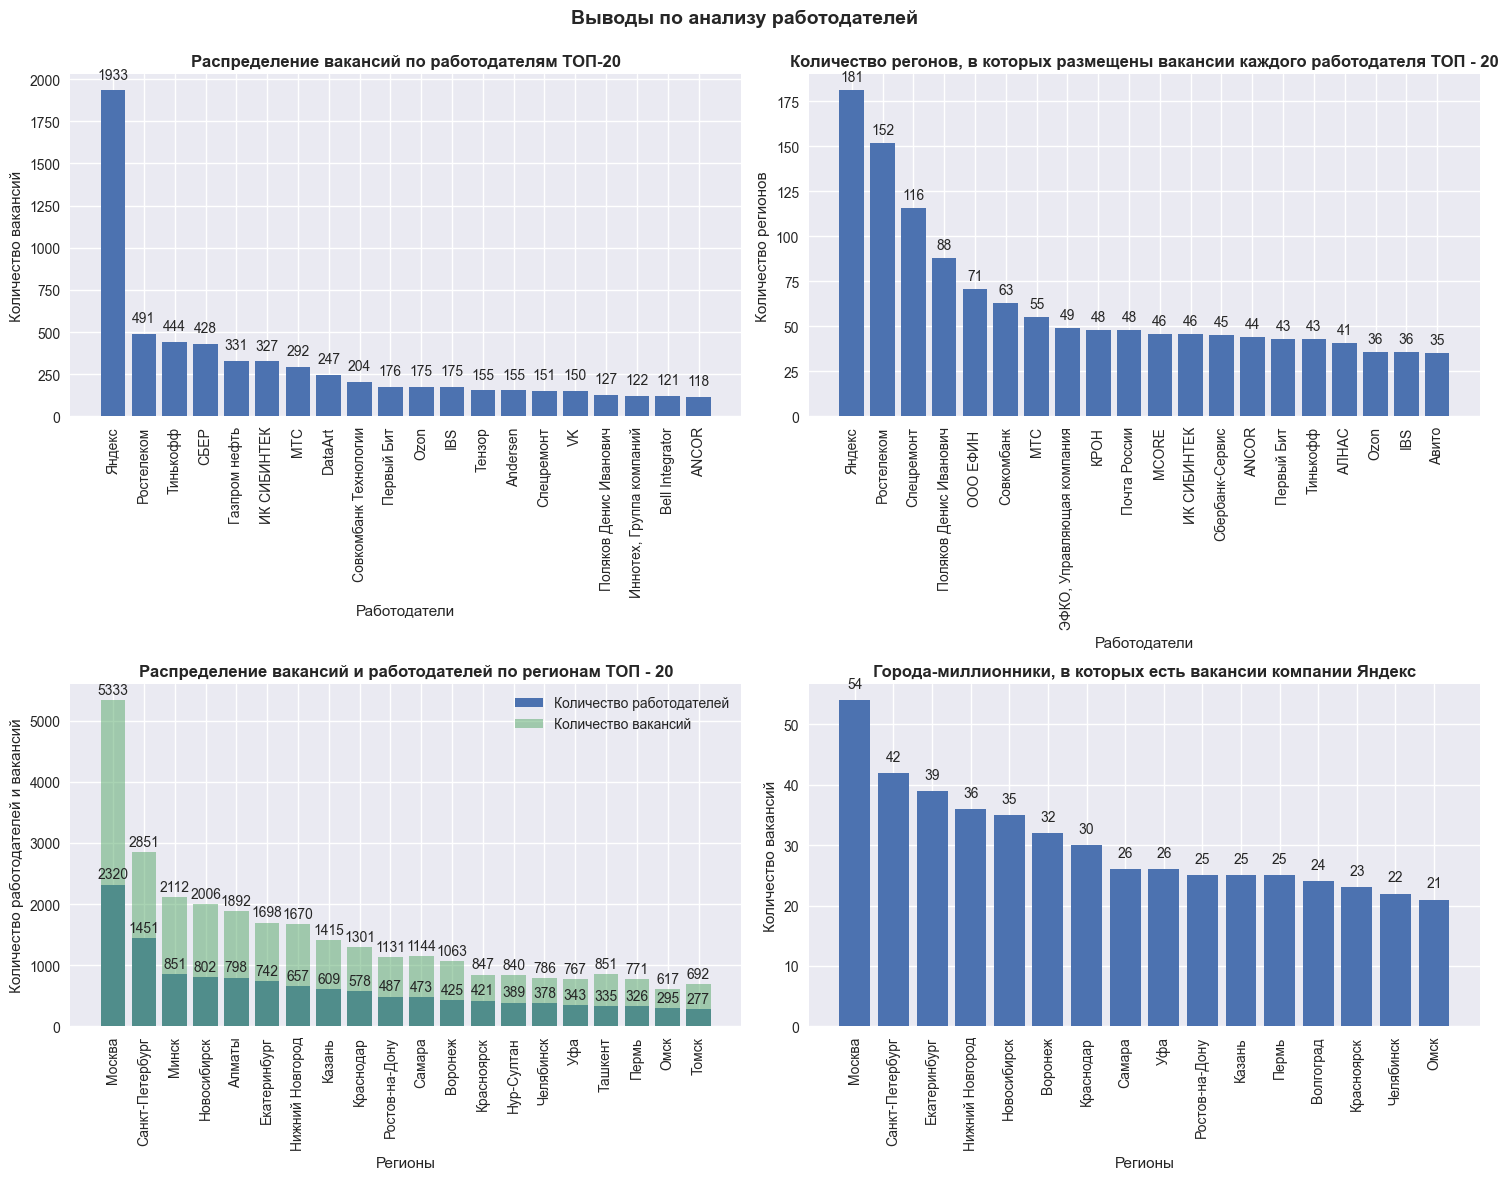

In [478]:
# выводы по анализу работодателей
# работодатели и количество вакансий
query_5_1 = '''select
                    e.name "Работодатель",
                    count(v.id) "Количество вакансий"                   
                from
                    public.vacancies v
                join 
                    public.employers e on e.id = v.employer_id
                group by 1
                order by count(v.id) desc
                                             
'''
employer_vac_qty = pd.read_sql_query(query_5_1, connection)
#display(employer_vac_qty)

# регионы, вакансии и работодатели
# display(employer_qty_area)

# распределение работодателей по регионама
# display(employer_area)

# города, в которых размещены вакансии компании "Яндекс"
# display(cities_yandex)

plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.suptitle('Выводы по анализу работодателей\n', fontsize=14, fontweight='bold')

# работодатели и количество вакансий
employer = employer_vac_qty['Работодатель'].to_list()[:20]
vacancies = employer_vac_qty['Количество вакансий'].to_list()[:20]
ax1 = axes[0, 0]
ax1.bar(employer, vacancies)
ax1.set_title("Распределение вакансий по работодателям ТОП-20", fontweight='bold')
ax1.set_ylabel("Количество вакансий")
ax1.set_xlabel("Работодатели")
ax1.tick_params(axis='x', rotation=90)
for i, v in enumerate(vacancies):
    ax1.text(i, v + 70, str(v), ha='center')

# регионы, вакансии и работодатели
regions = employer_qty_area['Регион'].to_list()[:20]
employers = employer_qty_area['Количество работодателей'].to_list()[:20]
vacancies = employer_qty_area['Количество вакансий'].to_list()[:20]
ax2 = axes[1, 0]
ax2.bar(regions, employers, label='Количество работодателей')
ax2.bar(regions, vacancies, label='Количество вакансий', alpha=0.5)
ax2.set_title("Распределение вакансий и работодателей по регионам ТОП - 20", fontweight='bold')
ax2.set_ylabel("Количество работодателей и вакансий")
ax2.set_xlabel("Регионы")
ax2.tick_params(axis='x', rotation=90)
ax2.legend()
for i, v in enumerate(employers):
    ax2.text(i, v + 100, str(v), ha='center')
for i, v in enumerate(vacancies):
    ax2.text(i, v + 100, str(v), ha='center')

# работодатели и регионы
employer = employer_area['Работодатель'].to_list()[:20]
regions_qty = employer_area['Количество регионов'].to_list()[:20]
ax3 = axes[0, 1]
ax3.bar(employer, regions_qty)
ax3.set_title("Количество регонов, в которых размещены вакансии каждого работодателя ТОП - 20", fontweight='bold')
ax3.set_ylabel("Количество регионов")
ax3.set_xlabel("Работодатели")
ax3.tick_params(axis='x', rotation=90)
for i, v in enumerate(regions_qty):
    ax3.text(i, v + 5, str(v), ha='center')
 
# Города-миллионники, в которых есть вакансии компании Яндекс   
city = cities_yandex['Город'].to_list()[15::-1]
city_vac = cities_yandex['Количество вакансий'].to_list()[15::-1]
ax4 = axes[1, 1]
ax4.bar(city, city_vac)
ax4.set_title("Города-миллионники, в которых есть вакансии компании Яндекс", fontweight='bold')
ax4.set_ylabel("Количество вакансий")
ax4.set_xlabel("Регионы")
ax4.tick_params(axis='x', rotation=90)
for i, v in enumerate(city_vac):
    ax4.text(i, v + 2, str(v), ha='center')

# Отобразить графики
plt.tight_layout()
plt.show()


# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [479]:
# текст запроса
vac_to_search = ['%data%', '%данн%']
query_6_1 = f'''select
                    'Вакансии, имеющие отношения к данным' "Тип вакансии",
                    count(v.id) "Количество вакансий"                                                      
                from
                    public.vacancies v                       
                where 
                    v.name ilike any (array{vac_to_search})  
                
                union all
                
                select
                    'Прочие вакансии',
                    count(v.id) "Количество вакансий"                                                      
                from
                    public.vacancies v                       
                where 
                    v.name not ilike any (array{vac_to_search})                                                        
'''

In [480]:
# результат запроса
data_vacancies = pd.read_sql_query(query_6_1, connection)
answer = data_vacancies['Количество вакансий'][0]
display(data_vacancies)
print('')
print(f'Количество вакансий, имеющих отношения к данным: {answer}')

,Тип вакансии,Количество вакансий
0,"Вакансии, имеющие отношения к данным",1771
1,Прочие вакансии,49120



Количество вакансий, имеющих отношения к данным: 1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [481]:
# текст запроса
ds_vacan_list = ['%data scientist%', '%data science%', '%исследователь данных%', '%machine learning%', '%машинн%обучен%']

query_6_2 = f'''select
                    'Вакансии для начианающих дата-сайнтистов' "Тип вакансии",
                    count(*) "Количество вакансий"                                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and    
                    (v.name ilike '%junior%' or v.experience = 'Нет опыта' or v.employment = 'Стажировка')
                    
                union all
                
                select
                    'Вакансии для middle и senior дата-сайнтистов',
                    count(*) "Количество вакансий"                                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and    
                    (v.name not ilike '%junior%' and v.experience != 'Нет опыта' and v.employment != 'Стажировка')                                  
'''

In [482]:
# результат запроса
ds_vacancies_count = pd.read_sql_query(query_6_2, connection)
display(ds_vacancies_count)
answer = ds_vacancies_count['Количество вакансий'][0]
print('')
print(f'Количество вакансий, подходящие начинающим дата-сайнтистам: {answer}')

,Тип вакансии,Количество вакансий
0,Вакансии для начианающих дата-сайнтистов,51
1,Вакансии для middle и senior дата-сайнтистов,429



Количество вакансий, подходящие начинающим дата-сайнтистам: 51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [483]:
# текст запроса
ds_vacan_list = ['%data scientist%', '%data science%', '%исследователь данных%', '%machine learning%', '%машинн%обучен%']

query_6_3 = f'''select
                    'Ключевые навыки: SQL и postgres' "Ключевые навыки",
                    count(*) "Количество вакансий"                                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and    
                    v.key_skills ilike any (array['%SQL%', '%postgres%'])  
                
                union all
                
                select
                    'Прочие навыки',
                    count(*) "Количество вакансий"                                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and    
                    v.key_skills not ilike all (array['%SQL%', '%postgres%'])                                   
'''

In [484]:
# результат запроса
ds_vacancies_count_sql = pd.read_sql_query(query_6_3, connection)
display(ds_vacancies_count_sql)
answer = ds_vacancies_count_sql['Количество вакансий'][0]
print('')
print(f'Количество вакансий, в которых в качестве ключевого навыка указан SQL или postgres: {answer}')

,Ключевые навыки,Количество вакансий
0,Ключевые навыки: SQL и postgres,201
1,Прочие навыки,230



Количество вакансий, в которых в качестве ключевого навыка указан SQL или postgres: 201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [485]:
# текст запроса
ds_vacan_list = ['%data scientist%', '%data science%', '%исследователь данных%', '%machine learning%', '%машинн%обучен%']

query_6_4 = f'''select
                    'Ключевые навыки: Python' "Ключевые навыки",
                    count(*) "Количество вакансий"                                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and    
                    v.key_skills ilike '%python%'
                
                union all
                
                select
                    'Прочие навыки',
                    count(*) "Количество вакансий"                                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and    
                    v.key_skills not ilike '%python%'
'''

In [486]:
# результат запроса
ds_vacancies_count_python = pd.read_sql_query(query_6_4, connection)
display(ds_vacancies_count_python)
answer = ds_vacancies_count_python['Количество вакансий'][0]
print('')
print(f'Количество вакансий, в которых в качестве ключевого навыка указан Python: {answer}')

,Ключевые навыки,Количество вакансий
0,Ключевые навыки: Python,351
1,Прочие навыки,80



Количество вакансий, в которых в качестве ключевого навыка указан Python: 351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [493]:
# текст запроса
ds_vacan_list = ['%data scientist%', '%data science%', '%исследователь данных%', '%machine learning%', '%машинн%обучен%']

query_6_5 = f'''select
                    avg(length(v.key_skills) - length(replace(v.key_skills, chr(9), '')) + 1)::numeric(3, 2) "Навыки"                                   
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and
                    v.key_skills is not null
'''

query_6_5_1 = f'''select
                    (length(v.key_skills) - length(replace(v.key_skills, chr(9), '')) + 1) "Количество навыков DS",
                    count(*) "Количество вакансий"                                    
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and
                    v.key_skills is not null
                group by
                    1
'''                    

In [494]:
ds_avg_skills = pd.read_sql_query(query_6_5, connection)
answer = ds_avg_skills['Навыки'][0]
print(f'Среднее количество навыков, которые указывают в вакансиях для DS: {answer}')

ds_vac_skills_qty = pd.read_sql_query(query_6_5_1, connection)
display(ds_vac_skills_qty)

Среднее количество навыков, которые указывают в вакансиях для DS: 6.41


,Количество навыков DS,Количество вакансий
0,1,4
1,2,12
2,3,27
3,4,34
4,5,146
5,6,68
6,7,25
7,8,33
8,9,28
9,10,8


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [489]:
# текст запроса
ds_vacan_list = ['%data scientist%', '%data science%', '%исследователь данных%', '%machine learning%', '%машинн%обучен%']

query_6_6 = f'''select
                    v.experience "Опыт работы",                                        
                    round(avg((coalesce(salary_from, 0, null) + coalesce(salary_to, 0, null)) / (coalesce(salary_from, 0, null) / coalesce(salary_from, 1, null) + coalesce(salary_to, 0, null)/ coalesce(salary_to, 1, null)))) "Средняя ЗП" 
                from
                    public.vacancies v                       
                where 
                    ((v.name ilike any (array{ds_vacan_list}) or v.name like '%ML%') and v.name not ilike '%HTML%')
                and
                    (salary_from is not null or salary_to is not null)
                group by v.experience
'''

In [490]:
# результат запроса
ds_avg_salary = pd.read_sql_query(query_6_6, connection) 
display(ds_avg_salary)
print('')
answer = ds_avg_salary['Средняя ЗП'][2]
print(f'Средняя зарплата, на которую может рассчитывать дата-сайнтист с опытом от 3 до 6 лет составляет: {answer} р.')

,Опыт работы,Средняя ЗП
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0



Средняя зарплата, на которую может рассчитывать дата-сайнтист с опытом от 3 до 6 лет составляет: 243115.0 р.


***

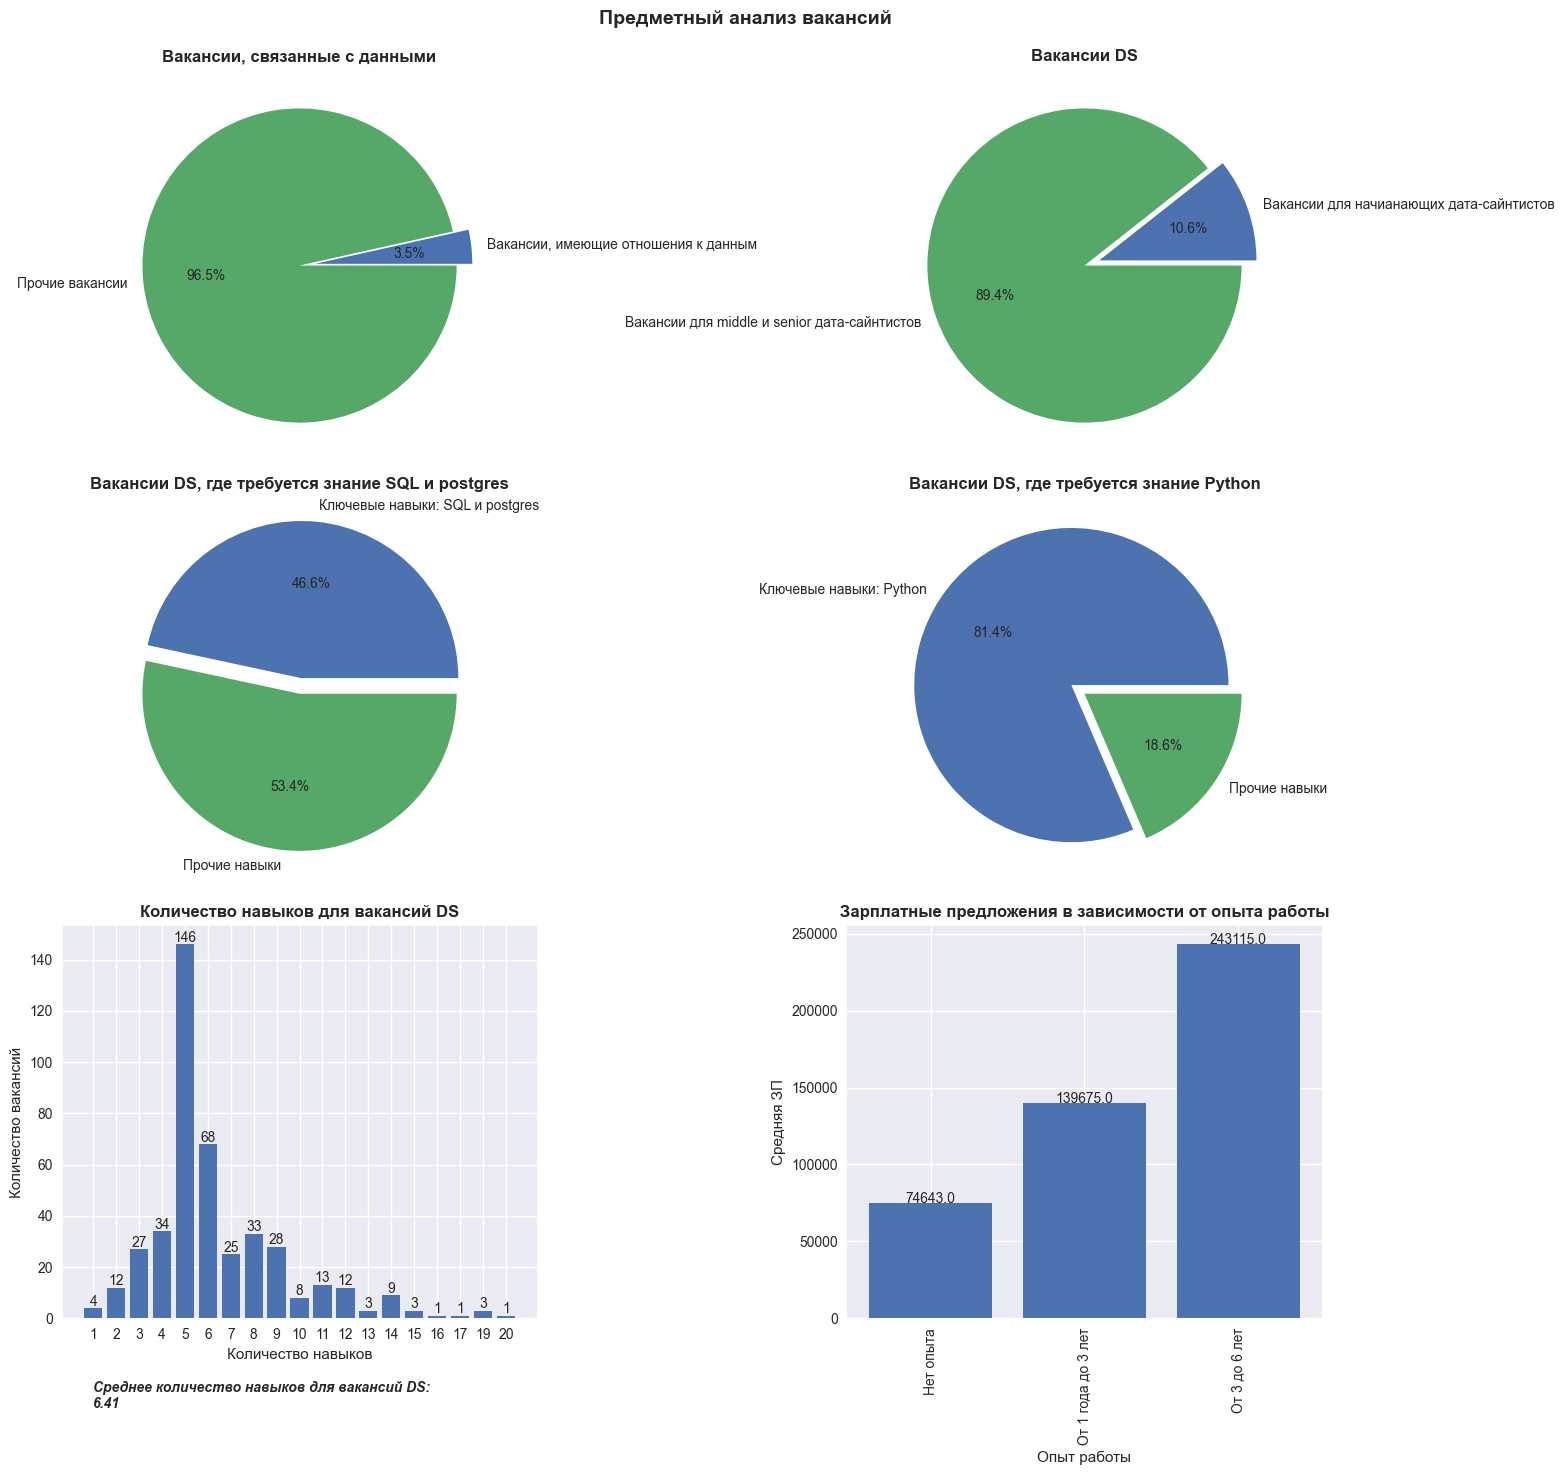

In [497]:
# выводы по предметному анализу

# Данные для первого pie chart
data_vacancies_data = data_vacancies['Количество вакансий'].to_list()
data_vacancies_labels= data_vacancies['Тип вакансии'].to_list()

# Данные для второго pie chart
ds_vacancies_count_data = ds_vacancies_count['Количество вакансий'].to_list()
ds_vacancies_count_labels = ds_vacancies_count['Тип вакансии'].to_list()

# Данные для третьго pie chart
ds_vacancies_count_sql_data = ds_vacancies_count_sql['Количество вакансий'].to_list()
ds_vacancies_count_sql_labels = ds_vacancies_count_sql['Ключевые навыки'].to_list()

# Данные для четвертого pie chart
ds_vacancies_count_python_data = ds_vacancies_count_python['Количество вакансий'].to_list()
ds_vacancies_count_python_labels = ds_vacancies_count_python['Ключевые навыки'].to_list()

# Данные для пятого pie chart
ds_vac_skills_qty_y = ds_vac_skills_qty['Количество вакансий'].to_list()
ds_vac_skills_qty_x = ds_vac_skills_qty['Количество навыков DS'].astype('str').to_list()

# Данные для шестого pie chart
ds_avg_salary_y = ds_avg_salary['Средняя ЗП'].to_list()
ds_avg_salary_x = ds_avg_salary['Опыт работы'].to_list()

# Создание subplot
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Предметный анализ вакансий\n', fontsize=14, fontweight='bold')

# Pie chart для Требуемого опыта работы
ax1 = axes[0, 0]
ax1.pie(data_vacancies_data, labels=data_vacancies_labels, autopct='%1.1f%%', explode=(0.1 , 0))
ax1.set_title("Вакансии, связанные с данными", fontweight='bold')

# Pie chart для Требуемого опыта работы
ax2 = axes[0, 1]
ax2.pie(ds_vacancies_count_data, labels=ds_vacancies_count_labels, autopct='%1.1f%%', explode=(0.1 , 0))
ax2.set_title("Вакансии DS", fontweight='bold')

# Pie chart для Требуемого опыта работы
ax3 = axes[1, 0]
ax3.pie(ds_vacancies_count_sql_data, labels=ds_vacancies_count_sql_labels, autopct='%1.1f%%', explode=(0.1 , 0))
ax3.set_title("Вакансии DS, где требуется знание SQL и postgres", fontweight='bold')

# Pie chart для Требуемого опыта работы
ax4 = axes[1, 1]
ax4.pie(ds_vacancies_count_python_data, labels=ds_vacancies_count_python_labels, autopct='%1.1f%%', explode=(0.1 , 0))
ax4.set_title("Вакансии DS, где требуется знание Python", fontweight='bold')

# Pie chart для Требуемого опыта работы
text = ds_avg_skills['Навыки'][0]
ax5 = axes[2, 0]
ax5.bar(ds_vac_skills_qty_x, ds_vac_skills_qty_y)
ax5.set_title("Количество навыков для вакансий DS", fontweight='bold')
ax5.set_ylabel("Количество вакансий")
ax5.set_xlabel("Количество навыков")
for i, v in enumerate(ds_vac_skills_qty_y):
    ax5.text(i, v + 1, str(v), ha='center')
ax5.text(0, -35,  f'Среднее количество навыков для вакансий DS:\n{text}', style='oblique', fontweight='bold')

# Pie chart для Указания ЗП
ax6 = axes[2, 1]
ax6.bar(ds_avg_salary_x, ds_avg_salary_y)
ax6.set_title("Зарплатные предложения в зависимости от опыта работы", fontweight='bold')
ax6.set_ylabel("Средняя ЗП")
ax6.set_xlabel("Опыт работы")
ax6.tick_params(axis='x', rotation=90)
for i, v in enumerate(ds_avg_salary_y):
    ax6.text(i, v + 10, str(v), ha='center')


# Отобразить графики
plt.tight_layout()
plt.show()

# Общий вывод по проекту

In [492]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования